<a href="https://colab.research.google.com/github/PrajwalKalpande/IPL-Score-and-Winner-Prediction/blob/main/IPL_NNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries and Pre-processed Data

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.subplots as subplots
import cufflinks as cf
%matplotlib inline
import pandas as pd
%matplotlib inline
import pandas as pd
import numpy as np
import math,os
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import choice
#import scikitplot as skplt
from time import time

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

In [35]:
from sklearn.linear_model import LinearRegression,Ridge,SGDRegressor,ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.validation import check_array 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix, classification_report,ConfusionMatrixDisplay
from sklearn.metrics import f1_score,accuracy_score , roc_auc_score,roc_curve,precision_score,recall_score
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor

In [ ]:
# import zipfile
# from google.colab import drive

# drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!gdown --id 1r94_CtQU6T_H5Ni2q4KmJMugEHYD2Mxk

Downloading...
From: https://drive.google.com/uc?id=1r94_CtQU6T_H5Ni2q4KmJMugEHYD2Mxk
To: /content/ipl_predict_dl.csv
100% 11.9M/11.9M [00:00<00:00, 92.0MB/s]


In [ ]:
data = pd.read_csv("/content/ipl_predict_dl.csv")

In [ ]:
data.drop(['Unnamed: 0'],axis = 1,inplace = True)
data.head()
 

,id_inning,year,inning,ball,venue,batsman,bowler,batting_team,bowling_team,is_wicket,total_runs_y,total_runs_x,team1_toss_win,team1_win,team1_bat,team1,team2,current_runs,current_wickets,runs_last5,wickets_last5
0,3359827,2008,1,5.1,14,431,264,7,12,0,4,222,1.0,0.0,0,12,7,54,0,54.0,0.0
1,3359827,2008,1,5.2,14,431,264,7,12,0,1,222,1.0,0.0,0,12,7,55,0,55.0,0.0
2,3359827,2008,1,5.3,14,77,264,7,12,0,4,222,1.0,0.0,0,12,7,59,0,59.0,0.0
3,3359827,2008,1,5.4,14,77,264,7,12,0,0,222,1.0,0.0,0,12,7,59,0,59.0,0.0
4,3359827,2008,1,5.5,14,77,264,7,12,0,1,222,1.0,0.0,0,12,7,60,0,59.0,0.0


# Neural Network for Score Prediction

### Defining Custom Functions for Evaluation

Defining custom accuracy for score prediction

In [ ]:
def custom_accuracy(y_test,y_pred,threshold=10):
    right = 0
    l = y_test.shape[0]
    for i in range(0,l-1):
        if(abs(y_pred[i]-y_test[i]) <= threshold):
            right += 1
        
    return ((right/l)*100)
#If predicted score is within 10 runs margin of actual score it is treated as correct prediction

Plot predicted and actual values

In [ ]:
def plotvals(y_test,y_pred) :

  fig = plt.figure(figsize=(9,6))
  xaxis = np.arange(1, y_pred.shape[0]+1,1)
  sns.kdeplot(y_pred, shade=True, color="g", label="Predicted Values", alpha=.7)
  sns.kdeplot(y_test, shade=True, color="dodgerblue", label="Actual Values", alpha=.7)
  
  plt.title('Predicting Final Scores', fontsize=16)
  plt.legend()
  plt.show()

Function to return evaluation metrics for model

In [ ]:
def eval(y_test,y_pred,threshold=10) :
  mae = mean_absolute_error(y_test , y_pred)
  rmse=  np.sqrt(mean_squared_error(y_test, y_pred))
  r2 = r2_score(y_test,y_pred)
  acc = custom_accuracy(y_test,y_pred,threshold)
  return {"MAE":mae,"RMSE":rmse,"R2score":r2,"Custom Accuracy":acc}

Function to evaluate classification model

In [36]:
def class_report(y_test,y_pred):
  f1 = f1_score(y_test,y_pred)
  acc = accuracy_score(y_test,y_pred)
  rocauc = roc_auc_score(y_test,y_pred)
  precision = precision_score(y_test,y_pred)
  recall=recall_score(y_test,y_pred) 
  return {'F1_score':f1,'Accuracy':acc,'Area under ROC curve':rocauc,'Precision':precision,'Recall':recall}

### Preparing Data for Model Training

Removing the old data (2008-2012)

In [ ]:
X_test_data = data[data['year']==2020]
X_train_data=data[data['year']<2020]
X_train_data = X_train_data[X_train_data['year']>2012]

In [ ]:
X_train_data.head()

,id_inning,year,inning,ball,venue,batsman,bowler,batting_team,bowling_team,is_wicket,total_runs_y,total_runs_x,team1_toss_win,team1_win,team1_bat,team1,team2,current_runs,current_wickets,runs_last5,wickets_last5
31389,5979983,2013,1,5.1,7,137,200,3,7,0,4,128,1.0,1.0,0,7,3,38,1,42.0,2.0
31390,5979983,2013,1,5.2,7,137,200,3,7,0,0,128,1.0,1.0,0,7,3,38,1,40.0,2.0
31391,5979983,2013,1,5.3,7,137,200,3,7,0,1,128,1.0,1.0,0,7,3,39,1,39.0,2.0
31392,5979983,2013,1,5.4,7,116,200,3,7,0,1,128,1.0,1.0,0,7,3,40,1,40.0,1.0
31393,5979983,2013,1,5.5,7,137,200,3,7,0,1,128,1.0,1.0,0,7,3,41,1,41.0,0.0


In [ ]:
X_train_data.columns

Index(['id_inning', 'year', 'inning', 'ball', 'venue', 'batsman', 'bowler',
       'batting_team', 'bowling_team', 'is_wicket', 'total_runs_y',
       'total_runs_x', 'team1_toss_win', 'team1_win', 'team1_bat', 'team1',
       'team2', 'current_runs', 'current_wickets', 'runs_last5',
       'wickets_last5'],
      dtype='object')

In [ ]:
features = data.columns[[2,3,4,5,6,12,14,15,16,17,-1,-2]]
X_train_data.rename(columns={'total_runs_x': 'final_score'}, inplace=True)
X_test_data.rename(columns={'total_runs_x': 'final_score'}, inplace=True)
target = X_train_data.columns[11]
print(features)
print(target)

Index(['inning', 'ball', 'venue', 'batsman', 'bowler', 'team1_toss_win',
       'team1_bat', 'team1', 'team2', 'current_runs', 'wickets_last5',
       'runs_last5'],
      dtype='object')
final_score


In [ ]:
X_train = X_train_data[features]
X_test = X_test_data[features]
y_train = X_train_data[target]
y_test = X_test_data[target]

In [ ]:
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
X_train

array([[0.        , 0.        , 0.2       , ..., 0.12109375, 0.25      ,
        0.32380952],
       [0.        , 0.00632911, 0.2       , ..., 0.12109375, 0.25      ,
        0.3047619 ],
       [0.        , 0.01265823, 0.2       , ..., 0.125     , 0.25      ,
        0.2952381 ],
       ...,
       [1.        , 0.96835443, 0.68571429, ..., 0.54296875, 0.25      ,
        0.48571429],
       [1.        , 0.97468354, 0.68571429, ..., 0.55078125, 0.25      ,
        0.5047619 ],
       [1.        , 0.98101266, 0.68571429, ..., 0.55078125, 0.375     ,
        0.4952381 ]])

## Defining NN Architecture

In [ ]:
callback = EarlyStopping(monitor='loss', patience=3)

In [ ]:

def create_model(a,b,c,d,e,f,num_epochs,af,drop,opt,lossfn):
  nn_model = Sequential()
  # The Input Layer :
  nn_model.add(Dense(a, kernel_initializer='he_normal', activation=af))
  nn_model.add(Dropout(0.3))
  nn_model.add(BatchNormalization(momentum = 0.9))

  # The Hidden Layers :
  nn_model.add(Dense(b, kernel_initializer='he_normal',activation=af))
  nn_model.add(Dropout(drop))
  nn_model.add(BatchNormalization(momentum = 0.9,epsilon=1e-05))

  nn_model.add(Dense(c, kernel_initializer='he_normal',activation=af))
  nn_model.add(Dropout(drop))
  nn_model.add(BatchNormalization(momentum = 0.9,epsilon=1e-05))

  nn_model.add(Dense(d, kernel_initializer='he_normal',activation=af))
  nn_model.add(Dropout(drop))
  nn_model.add(BatchNormalization(momentum = 0.9,epsilon=1e-05))

  nn_model.add(Dense(e, kernel_initializer='he_normal',activation=af))
  nn_model.add(Dropout(drop))
  nn_model.add(BatchNormalization(momentum = 0.9,epsilon=1e-05 ))
  
  nn_model.add(Dense(f, kernel_initializer='he_normal',activation=af))
  nn_model.add(Dropout(drop))
  nn_model.add(BatchNormalization(momentum = 0.9,epsilon=1e-05))

  # The Output Layer :
  nn_model.add(Dense(1))

  # Compile the network :
  nn_model.compile(loss=lossfn, optimizer=opt,metrics=[tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.MeanAbsoluteError()])
  history = nn_model.fit(x=X_train, y=y_train, epochs=num_epochs,validation_data=(X_test,y_test),callbacks=[callback],verbose=0 )
  summary = nn_model.summary()
  score = nn_model.evaluate(X_test,y_test,verbose =0)
  return nn_model ,history ,summary ,score

          

### Tuning Loss Function

In [ ]:
m1, h1, sum1, score1 = create_model(64, 128, 256, 128, 128, 64,100,'linear',0.3,'adam','mse')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 64)                832       
                                                                 
 dropout_30 (Dropout)        (None, 64)                0         
                                                                 
 batch_normalization_30 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_36 (Dense)            (None, 128)               8320      
                                                                 
 dropout_31 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_31 (Bat  (None, 128)              512       
 chNormalization)                                     

In [ ]:
print(h1.history.keys())

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


In [ ]:
print(score1)
# mse mse mae

[363.7919921875, 363.7919921875, 14.634840965270996]


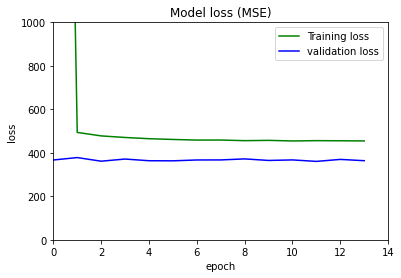

In [ ]:
# summarize history for loss
plt.plot(h1.history['loss'],'g',label='Training loss')
plt.plot(h1.history['val_loss'],'b',label='validation loss')
plt.title('Model loss (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.axis([0,14,0,1000])
plt.show()

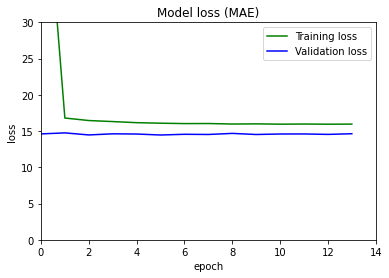

In [ ]:
plt.plot(h1.history['mean_absolute_error'],'g',label='Training loss')
plt.plot(h1.history['val_mean_absolute_error'],'b',label='Validation loss')
plt.title('Model loss ')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.axis([0,14,0,30])
plt.show()

In [ ]:
y_pred = m1.predict(X_test).reshape(-1)

In [ ]:
y_pred

array([181.41806, 185.01715, 183.89774, ..., 166.34824, 162.07614,
       162.47258], dtype=float32)

In [ ]:
result = eval(y_test.values,y_pred)

In [ ]:
print(result)

{'MAE': 14.634849075353156, 'RMSE': 19.073331568413344, 'R2score': 0.5404468294032202, 'Custom Accuracy': 43.83954154727794}


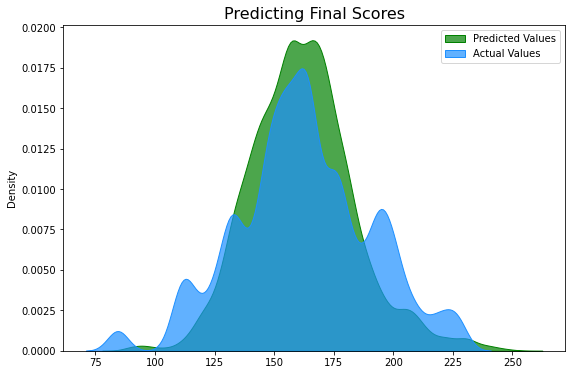

In [ ]:
plotvals(y_test.values,y_pred)

In [ ]:
m2, h2, sum2, score2 = create_model(64, 128, 256, 128, 128, 64,100,'linear',0.3,'adam','mae')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (None, 64)                832       
                                                                 
 dropout_42 (Dropout)        (None, 64)                0         
                                                                 
 batch_normalization_42 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_50 (Dense)            (None, 128)               8320      
                                                                 
 dropout_43 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_43 (Bat  (None, 128)              512       
 chNormalization)                                     

In [ ]:
print(score2)
# mae mse mae

[14.443499565124512, 362.9517822265625, 14.443499565124512]


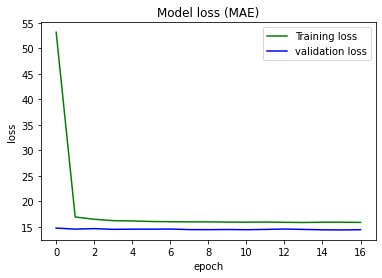

In [ ]:
# summarize history for loss
plt.plot(h2.history['loss'],'g',label='Training loss')
plt.plot(h2.history['val_loss'],'b',label='validation loss')
plt.title('Model loss (MAE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.axis([0,14,0,1000])
plt.show()

In [ ]:
h2.history.keys()

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])

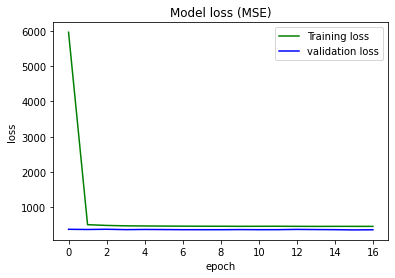

In [ ]:
# summarize history for loss
plt.plot(h2.history['mean_squared_error'],'g',label='Training loss')
plt.plot(h2.history['val_mean_squared_error'],'b',label='validation loss')
plt.title('Model loss (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
# plt.axis([0,14,0,1000])
plt.show()

In [ ]:
y_pred = m2.predict(X_test)
result = eval(y_test.values,y_pred)

In [ ]:
print(result)

{'MAE': 14.443500994766525, 'RMSE': 19.0512916207314, 'R2score': 0.5415082775151487, 'Custom Accuracy': 46.25336459147347}


MAE performed slightly better

### Experimenting with more hidden layers

In [ ]:

def create_model_big(a,b,c,d,e,f,g,h,num_epochs,af,drop,opt,lossfn):
  nn_model = Sequential()
  # The Input Layer :
  nn_model.add(Dense(a, kernel_initializer='he_normal', activation=af))
  nn_model.add(Dropout(0.3))
  nn_model.add(BatchNormalization(momentum = 0.9))

  # The Hidden Layers :
  nn_model.add(Dense(b, kernel_initializer='he_normal',activation=af))
  nn_model.add(Dropout(drop))
  nn_model.add(BatchNormalization(momentum = 0.9,epsilon=1e-05))

  nn_model.add(Dense(c, kernel_initializer='he_normal',activation=af))
  nn_model.add(Dropout(drop))
  nn_model.add(BatchNormalization(momentum = 0.9,epsilon=1e-05))

  nn_model.add(Dense(d, kernel_initializer='he_normal',activation=af))
  nn_model.add(Dropout(drop))
  nn_model.add(BatchNormalization(momentum = 0.9,epsilon=1e-05))

  nn_model.add(Dense(e, kernel_initializer='he_normal',activation=af))
  nn_model.add(Dropout(drop))
  nn_model.add(BatchNormalization(momentum = 0.9,epsilon=1e-05 ))
  
  nn_model.add(Dense(f, kernel_initializer='he_normal',activation=af))
  nn_model.add(Dropout(drop))
  nn_model.add(BatchNormalization(momentum = 0.9,epsilon=1e-05))

  nn_model.add(Dense(g, kernel_initializer='he_normal',activation=af))
  nn_model.add(Dropout(drop))
  nn_model.add(BatchNormalization(momentum = 0.9,epsilon=1e-05))

  nn_model.add(Dense(h, kernel_initializer='he_normal',activation=af))
  nn_model.add(Dropout(drop))
  nn_model.add(BatchNormalization(momentum = 0.9,epsilon=1e-05))
  # The Output Layer :
  nn_model.add(Dense(1))

  # Compile the network :
  nn_model.compile(loss=lossfn, optimizer=opt,metrics=['accuracy',tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.MeanAbsoluteError()])
  history = nn_model.fit(x=X_train, y=y_train, epochs=num_epochs,validation_data=(X_test,y_test),callbacks=[callback],verbose=0 )
  summary = nn_model.summary()
  score = nn_model.evaluate(X_test,y_test,verbose =0)
  return nn_model ,history ,summary ,score

          

In [ ]:
m3, h3, sum3, score3 = create_model_big(64, 128, 256, 128,256, 128, 64,32,100,'linear',0.3,'adam','mae')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 64)                832       
                                                                 
 dropout_48 (Dropout)        (None, 64)                0         
                                                                 
 batch_normalization_48 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_57 (Dense)            (None, 128)               8320      
                                                                 
 dropout_49 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_49 (Bat  (None, 128)              512       
 chNormalization)                                     

In [ ]:
print(score3)

[14.622820854187012, 0.0, 371.3631286621094, 14.622820854187012]


In [ ]:
h3.history.keys()

dict_keys(['loss', 'accuracy', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_accuracy', 'val_mean_squared_error', 'val_mean_absolute_error'])

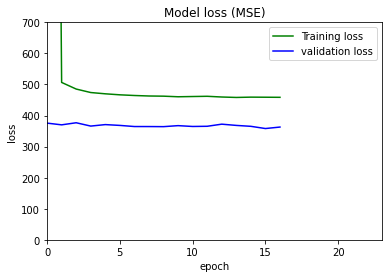

In [ ]:
# summarize history for loss
plt.plot(h2.history['mean_squared_error'],'g',label='Training loss')
plt.plot(h2.history['val_mean_squared_error'],'b',label='validation loss')
plt.title('Model loss (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.axis([0,23,0,700])
plt.show()

In [ ]:
y_pred = m3.predict(X_test)
result = eval(y_test.values,y_pred)

In [ ]:
print(result)

{'MAE': 14.622814977708309, 'RMSE': 19.270785554689734, 'R2score': 0.5308826591585063, 'Custom Accuracy': 46.18390205782756}


Accuracy is slightly less than before. This means increasing hidden layers isn't going to increase accuracy by much.

### Experimenting with Batch-Size

In [ ]:

def create_model_batch(a,b,c,d,e,f,num_epochs,af,drop,opt,lossfn,batch) :
  nn_model = Sequential()
  # The Input Layer :
  nn_model.add(Dense(a, kernel_initializer='he_normal', activation=af))
  nn_model.add(Dropout(0.3))
  nn_model.add(BatchNormalization(momentum = 0.9))

  # The Hidden Layers :
  nn_model.add(Dense(b, kernel_initializer='he_normal',activation=af))
  nn_model.add(Dropout(drop))
  nn_model.add(BatchNormalization(momentum = 0.9,epsilon=1e-05))

  nn_model.add(Dense(c, kernel_initializer='he_normal',activation=af))
  nn_model.add(Dropout(drop))
  nn_model.add(BatchNormalization(momentum = 0.9,epsilon=1e-05))

  nn_model.add(Dense(d, kernel_initializer='he_normal',activation=af))
  nn_model.add(Dropout(drop))
  nn_model.add(BatchNormalization(momentum = 0.9,epsilon=1e-05))

  nn_model.add(Dense(e, kernel_initializer='he_normal',activation=af))
  nn_model.add(Dropout(drop))
  nn_model.add(BatchNormalization(momentum = 0.9,epsilon=1e-05 ))
  
  nn_model.add(Dense(f, kernel_initializer='he_normal',activation=af))
  nn_model.add(Dropout(drop))
  nn_model.add(BatchNormalization(momentum = 0.9,epsilon=1e-05))

  # The Output Layer :
  nn_model.add(Dense(1))

  # Compile the network :
  nn_model.compile(loss=lossfn, optimizer=opt,metrics=[tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.MeanAbsoluteError()])
  history = nn_model.fit(x=X_train, y=y_train, epochs=num_epochs,validation_data=(X_test,y_test),callbacks=[callback],verbose=0,batch_size=batch )
  summary = nn_model.summary()
  score = nn_model.evaluate(X_test,y_test,verbose =0)
  return nn_model ,history ,summary ,score

          

By default, the batch size in tf.keras is 32

In [ ]:
m4, h4, sum4, score4 = create_model_batch(64, 128, 256, 128, 128, 64,100,'linear',0.3,'adam','mae',128)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_65 (Dense)            (None, 64)                832       
                                                                 
 dropout_56 (Dropout)        (None, 64)                0         
                                                                 
 batch_normalization_56 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_66 (Dense)            (None, 128)               8320      
                                                                 
 dropout_57 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_57 (Bat  (None, 128)              512       
 chNormalization)                                     

In [ ]:
y_pred = m4.predict(X_test)
result = eval(y_test.values,y_pred)

In [ ]:
print(result)

{'MAE': 14.453784262625781, 'RMSE': 19.062205448473673, 'R2score': 0.5409828188679499, 'Custom Accuracy': 45.60215333854302}


Accuracy reduced on increasing batch_size. Let us try decreasing once.

The results obtained for batch_size=16 are given below.

In [ ]:
print(result)

{'MAE': 14.565362438597054, 'RMSE': 19.1774901935152, 'R2score': 0.53541392527072, 'Custom Accuracy': 44.37787618303378}


Thus, 32 is the optimum batch-size

## Final Model

From the graphs it appears that the LR is high. So, let us try a lesser LR.

In [ ]:
m6, h6, sum6, score6 = create_model(64, 128, 256, 128, 128, 64,100,'linear',0.3,tf.keras.optimizers.Adam(learning_rate=1e-4),'mae')

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_79 (Dense)            (None, 64)                832       
                                                                 
 dropout_68 (Dropout)        (None, 64)                0         
                                                                 
 batch_normalization_68 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_80 (Dense)            (None, 128)               8320      
                                                                 
 dropout_69 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_69 (Bat  (None, 128)              512       
 chNormalization)                                    

In [ ]:
y_pred = m6.predict(X_test)
result = eval(y_test.values,y_pred)

In [ ]:
print(result)

{'MAE': 14.456662292559962, 'RMSE': 19.172152822587925, 'R2score': 0.5356724912373634, 'Custom Accuracy': 46.78301641052357}


There is slight increase in R2score and custom accuracy as compared to when LR was 1e-3.Thus, this is the best model obtained so far.

# Neural Network for Match Winner Prediction

### Preparing Data for Model Training


In [46]:
!gdown --id 1r94_CtQU6T_H5Ni2q4KmJMugEHYD2Mxk 

Downloading...
From: https://drive.google.com/uc?id=1r94_CtQU6T_H5Ni2q4KmJMugEHYD2Mxk
To: /content/ipl_predict_dl.csv
100% 11.9M/11.9M [00:00<00:00, 59.8MB/s]


In [47]:
data = pd.read_csv('/content/ipl_predict_dl.csv')

In [48]:
data.drop(['Unnamed: 0'],inplace=True,axis=1)
data.head()

,id_inning,year,inning,ball,venue,batsman,bowler,batting_team,bowling_team,is_wicket,total_runs_y,total_runs_x,team1_toss_win,team1_win,team1_bat,team1,team2,current_runs,current_wickets,runs_last5,wickets_last5
0,3359827,2008,1,5.1,14,431,264,7,12,0,4,222,1.0,0.0,0,12,7,54,0,54.0,0.0
1,3359827,2008,1,5.2,14,431,264,7,12,0,1,222,1.0,0.0,0,12,7,55,0,55.0,0.0
2,3359827,2008,1,5.3,14,77,264,7,12,0,4,222,1.0,0.0,0,12,7,59,0,59.0,0.0
3,3359827,2008,1,5.4,14,77,264,7,12,0,0,222,1.0,0.0,0,12,7,59,0,59.0,0.0
4,3359827,2008,1,5.5,14,77,264,7,12,0,1,222,1.0,0.0,0,12,7,60,0,59.0,0.0


In [49]:
data.drop('id_inning',axis=1,inplace=True)

### Feature selection

In [51]:
df_win = data.copy()
df_win.drop('year',axis=1,inplace=True)
# removing year from feature importance process

In [52]:
df_win.columns

Index(['inning', 'ball', 'venue', 'batsman', 'bowler', 'batting_team',
       'bowling_team', 'is_wicket', 'total_runs_y', 'total_runs_x',
       'team1_toss_win', 'team1_win', 'team1_bat', 'team1', 'team2',
       'current_runs', 'current_wickets', 'runs_last5', 'wickets_last5'],
      dtype='object')

In [53]:
df_win.drop('team1_win',axis=1,inplace=True)
df_win['team1_win']=data['team1_win']

In [57]:
df_win.drop(['batting_team','bowling_team','is_wicket','total_runs_y'],axis=1,inplace=True)

In [60]:
len(df_win.columns)

15

In [61]:
from sklearn.ensemble import ExtraTreesClassifier

In [62]:
X = df_win.iloc[:,0:14]  #independent columns
y = df_win.iloc[:,14]    #target column i.e price range
model = ExtraTreesClassifier()
model.fit(X ,y )
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)


[0.03581144 0.03304189 0.14226104 0.0644578  0.05358138 0.1831743
 0.02199369 0.02220407 0.1218707  0.14459187 0.04030439 0.06275777
 0.03919538 0.03475428]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



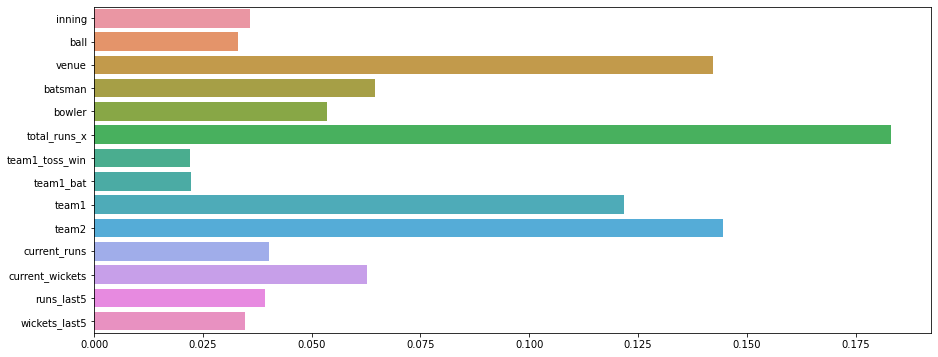

In [66]:
fig = plt.figure(figsize=(15,6))
sns.barplot(feat_importances.values,feat_importances.index)
plt.show()

In [67]:
feat_importances=feat_importances[feat_importances.values>0.025]
class_feature_columns=feat_importances.index

In [68]:
class_feature_columns

Index(['inning', 'ball', 'venue', 'batsman', 'bowler', 'total_runs_x', 'team1',
       'team2', 'current_runs', 'current_wickets', 'runs_last5',
       'wickets_last5'],
      dtype='object')

In [101]:
X_win_train_data= data[data['year']<2020] 
X_win_test_data= data[data['year']==2020] 
# X_win_train_data = X_win_train_data[X_win_train_data['year']>2012]

In [102]:
X_win_train_data.head()

,year,inning,ball,venue,batsman,bowler,batting_team,bowling_team,is_wicket,total_runs_y,total_runs_x,team1_toss_win,team1_win,team1_bat,team1,team2,current_runs,current_wickets,runs_last5,wickets_last5
0,2008,1,5.1,14,431,264,7,12,0,4,222,1.0,0.0,0,12,7,54,0,54.0,0.0
1,2008,1,5.2,14,431,264,7,12,0,1,222,1.0,0.0,0,12,7,55,0,55.0,0.0
2,2008,1,5.3,14,77,264,7,12,0,4,222,1.0,0.0,0,12,7,59,0,59.0,0.0
3,2008,1,5.4,14,77,264,7,12,0,0,222,1.0,0.0,0,12,7,59,0,59.0,0.0
4,2008,1,5.5,14,77,264,7,12,0,1,222,1.0,0.0,0,12,7,60,0,59.0,0.0


In [72]:
len(X_win_train_data)

140925

In [103]:
X_win_train = X_win_train_data.drop('year',axis=1)
X_win_test = X_win_test_data.drop('year',axis=1)

In [ ]:
class_feature_columns

Index(['venue', 'team1_toss_win', 'team1_bat', 'target_score', 'team1',
       'team2'],
      dtype='object')

In [104]:
X_win_train_data = X_win_train_data.drop('year',axis=1)
X_win_test_data = X_win_test_data.drop('year',axis=1)

In [105]:
X_win_train_data.head()

,inning,ball,venue,batsman,bowler,batting_team,bowling_team,is_wicket,total_runs_y,total_runs_x,team1_toss_win,team1_win,team1_bat,team1,team2,current_runs,current_wickets,runs_last5,wickets_last5
0,1,5.1,14,431,264,7,12,0,4,222,1.0,0.0,0,12,7,54,0,54.0,0.0
1,1,5.2,14,431,264,7,12,0,1,222,1.0,0.0,0,12,7,55,0,55.0,0.0
2,1,5.3,14,77,264,7,12,0,4,222,1.0,0.0,0,12,7,59,0,59.0,0.0
3,1,5.4,14,77,264,7,12,0,0,222,1.0,0.0,0,12,7,59,0,59.0,0.0
4,1,5.5,14,77,264,7,12,0,1,222,1.0,0.0,0,12,7,60,0,59.0,0.0


In [106]:
sc = StandardScaler()
X_train1 = sc.fit_transform(X_train)
X_test1 = sc.transform(X_test)
#standardizing the data

## Defining Model Architecture

In [77]:
callback = EarlyStopping(monitor='loss', patience=3)

In [78]:

def create_model(a,b,c,d,e,f,num_epochs,af1,af2,drop,lr):
  nn_model = Sequential()
  # The Input Layer :
  nn_model.add(Dense(a, kernel_initializer='he_normal', activation=af1))
  nn_model.add(Dropout(0.3))
  nn_model.add(BatchNormalization(momentum = 0.9))

  # The Hidden Layers :
  nn_model.add(Dense(b, kernel_initializer='he_normal',activation=af2))
  nn_model.add(Dropout(drop))
  nn_model.add(BatchNormalization(momentum = 0.9,epsilon=1e-05))

  nn_model.add(Dense(c, kernel_initializer='he_normal',activation=af1))
  nn_model.add(Dropout(drop))
  nn_model.add(BatchNormalization(momentum = 0.9,epsilon=1e-05))

  nn_model.add(Dense(d, kernel_initializer='he_normal',activation=af2))
  nn_model.add(Dropout(drop))
  nn_model.add(BatchNormalization(momentum = 0.9,epsilon=1e-05))

  nn_model.add(Dense(e, kernel_initializer='he_normal',activation=af1))
  nn_model.add(Dropout(drop))
  nn_model.add(BatchNormalization(momentum = 0.9,epsilon=1e-05 ))
  
  nn_model.add(Dense(f, kernel_initializer='he_normal',activation=af2))
  nn_model.add(Dropout(drop))
  nn_model.add(BatchNormalization(momentum = 0.9,epsilon=1e-05))

  # The Output Layer :
  nn_model.add(Dense(1))

  # Compile the network :
  nn_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr),metrics=[ 'accuracy'])
  history = nn_model.fit(x=X_train, y=y_train, epochs=num_epochs,validation_data=(X_test,y_test),callbacks=[callback],verbose=0 )
  summary = nn_model.summary()
  score = nn_model.evaluate(X_test,y_test,verbose =0)
  return nn_model ,history ,summary ,score

          

In [80]:
model1 , hist1 , sum1, win_score1 = create_model(16, 32, 64, 64, 32, 16,100,'relu','relu',0.3,1e-03)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (None, 16)                208       
                                                                 
 dropout_42 (Dropout)        (None, 16)                0         
                                                                 
 batch_normalization_42 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 dense_50 (Dense)            (None, 32)                544       
                                                                 
 dropout_43 (Dropout)        (None, 32)                0         
                                                                 
 batch_normalization_43 (Bat  (None, 32)               128       
 chNormalization)                                     

In [81]:
print(f"Binary cross-entropy loss is :{ win_score1[0]}")
print(f"Accuracy is :{win_score1[1]}")

Binary cross-entropy loss is :0.7017940878868103
Accuracy is :0.5384214520454407


In [84]:
y_pred = model1.predict(X_test)
thresh= np.where(y_pred>0.5 ,1,0)

In [85]:
class_report(y_test.values,thresh)

{'Accuracy': 0.5384214639228966,
 'Area under ROC curve': 0.5341825446258415,
 'F1_score': 0.6017380881030867,
 'Precision': 0.5413128453969538,
 'Recall': 0.6773486254005735}

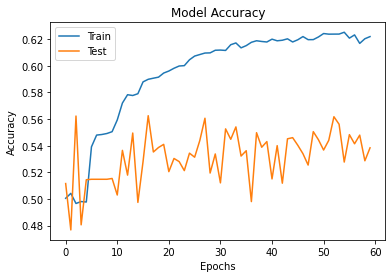

In [86]:
# summarize history for accuracy
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


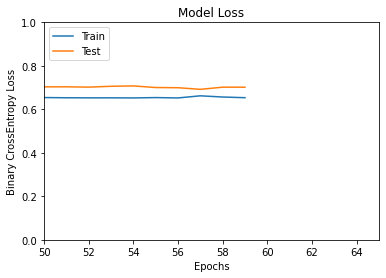

In [88]:
# summarize history for accuracy
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Binary CrossEntropy Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.axis([50,65,0,1])
plt.show()


Thus, although the model accuracies have converged it hasn't been able to genearalize well on the data. So, let us increase Regularization

### Trying Larger NN

In [107]:
model2 , hist2, sum2, win_score2 = create_model( 32, 64,128,128, 64, 32,100,'relu','relu',0.3,1e-03)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 32)                416       
                                                                 
 dropout_60 (Dropout)        (None, 32)                0         
                                                                 
 batch_normalization_60 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dense_71 (Dense)            (None, 64)                2112      
                                                                 
 dropout_61 (Dropout)        (None, 64)                0         
                                                                 
 batch_normalization_61 (Bat  (None, 64)               256       
 chNormalization)                                    

In [108]:
print(f"Binary cross-entropy loss is :{ win_score2[0]}")
print(f"Accuracy is :{win_score2[1]}")

Binary cross-entropy loss is :0.69221431016922
Accuracy is :0.5141095519065857


In [109]:
y_pred = model2.predict(X_test)
thresh= np.where(y_pred>0.5 ,1,0)

In [110]:
class_report(y_test.values,thresh)

{'Accuracy': 0.5141095771468265,
 'Area under ROC curve': 0.4993973967539772,
 'F1_score': 0.6785755313038483,
 'Precision': 0.5145022210608832,
 'Recall': 0.9962894248608535}

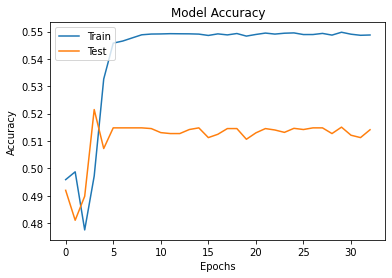

In [111]:
# summarize history for accuracy
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


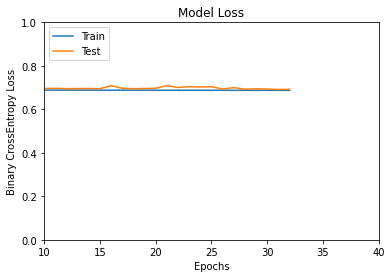

In [115]:
# summarize history for accuracy
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Binary CrossEntropy Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.axis([10,40,0,1])
plt.show()


Trying one more big network

In [122]:
model21, hist21, sum21, score21 = create_model( 64, 128, 256, 128, 128, 64,100,'relu','relu',0.3,1e-03)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 64)                832       
                                                                 
 dropout_72 (Dropout)        (None, 64)                0         
                                                                 
 batch_normalization_72 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_85 (Dense)            (None, 128)               8320      
                                                                 
 dropout_73 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_73 (Bat  (None, 128)              512       
 chNormalization)                                    

In [124]:
print(f"Binary cross-entropy loss is :{  score21[0]}")
print(f"Accuracy is :{ score21[1]}")

Binary cross-entropy loss is :0.7097652554512024
Accuracy is :0.5148041844367981


Thus, smaller NN has performed better. Let us now used softmax and see if accuracy improves

### Trying SoftMax activation function

In [117]:

def create_model_soft(a,b,c,d,e,f,num_epochs,af1,af2,drop,lr):
  nn_model = Sequential()
  # The Input Layer :
  nn_model.add(Dense(a, kernel_initializer='he_normal', activation=af1))
  nn_model.add(Dropout(0.3))
  nn_model.add(BatchNormalization(momentum = 0.9))

  # The Hidden Layers :
  nn_model.add(Dense(b, kernel_initializer='he_normal',activation=af2))
  nn_model.add(Dropout(drop))
  nn_model.add(BatchNormalization(momentum = 0.9,epsilon=1e-05))

  nn_model.add(Dense(c, kernel_initializer='he_normal',activation=af1))
  nn_model.add(Dropout(drop))
  nn_model.add(BatchNormalization(momentum = 0.9,epsilon=1e-05))

  nn_model.add(Dense(d, kernel_initializer='he_normal',activation=af2))
  nn_model.add(Dropout(drop))
  nn_model.add(BatchNormalization(momentum = 0.9,epsilon=1e-05))

  nn_model.add(Dense(e, kernel_initializer='he_normal',activation=af1))
  nn_model.add(Dropout(drop))
  nn_model.add(BatchNormalization(momentum = 0.9,epsilon=1e-05 ))
  
  nn_model.add(Dense(f, kernel_initializer='he_normal',activation=af2))
  nn_model.add(Dropout(drop))
  nn_model.add(BatchNormalization(momentum = 0.9,epsilon=1e-05))

  # The Output Layer :
  nn_model.add(Dense(1,activation='softmax'))

  # Compile the network :
  nn_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr),metrics=[ 'accuracy'])
  history = nn_model.fit(x=X_train, y=y_train, epochs=num_epochs,validation_data=(X_test,y_test),callbacks=[callback],verbose=0 )
  summary = nn_model.summary()
  score = nn_model.evaluate(X_test,y_test,verbose =0)
  return nn_model ,history ,summary ,score

          

In [118]:
model3 , hist3, sum3, win_score3 = create_model_soft( 16, 32, 64, 64, 32, 16,100,'relu','relu',0.3,1e-03)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_77 (Dense)            (None, 16)                208       
                                                                 
 dropout_66 (Dropout)        (None, 16)                0         
                                                                 
 batch_normalization_66 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 dense_78 (Dense)            (None, 32)                544       
                                                                 
 dropout_67 (Dropout)        (None, 32)                0         
                                                                 
 batch_normalization_67 (Bat  (None, 32)               128       
 chNormalization)                                    

In [119]:
print(f"Binary cross-entropy loss is :{ win_score3[0]}")
print(f"Accuracy is :{win_score3[1]}")

Binary cross-entropy loss is :0.6959964632987976
Accuracy is :0.5148041844367981


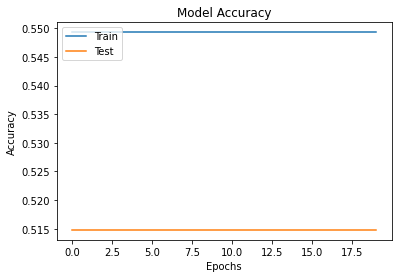

In [120]:
# summarize history for accuracy
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


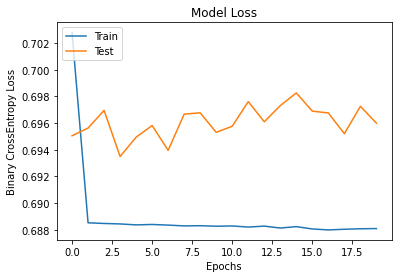

In [121]:
# summarize history for accuracy
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Binary CrossEntropy Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.axis([10,40,0,1])
plt.show()


The neural networks for winner prediction need to be tuned better.For now, the best model is the first one which was tried.